Modal SNA MAP473D, Ecole Polytechnique, 2022-23

# TP5 - Méthodes adaptatives multi-niveaux (AMS)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps
from time import perf_counter, sleep
from IPython.display import clear_output

## Exercice 1 : le cadre statique

On reprend l'exemple jouet du TP2. Pour un seuil $q$ donné, on veut appliquer l'algorithme de la dernière particule pour estimer la probabilité $p:=\mathbb{P}(\mathcal{N}(0,1)>q)$, avec typiquement $p$ très faible. Pour cela, il suffit de disposer d'un noyau de transition $P$ réversible pour la loi $\mathcal{N}(0,1)$, par exemple le noyau gaussien vu en TP2. Partant de $X$, ce noyau propose une transition en $\rho X+\sqrt{1-\rho^2}W$, avec $W\sim\mathcal{N}(0,1)$ indépendante de $X$ et $\rho\in]0,1[$ un paramètre de réglage. 

Pour un niveau $L$ donné, si $X\sim\mathcal{N}(0,1)|\mathcal{N}(0,1)>L$, alors
\begin{equation*}
X':= \begin{cases}\rho X+\sqrt{1-\rho^2} W &\textrm{ si $\rho X+\sqrt{1-\rho^2} W>L$}\\ X&\textrm{ sinon}\end{cases} 
\end{equation*}
vérifie encore $X'\sim\mathcal{N}(0,1)|\mathcal{N}(0,1)>L$. Si l'on applique un "grand" nombre $T$ de fois ce noyau, on obtient donc un nouveau point toujours distribué selon la loi $\mathcal{N}(0,1)|\mathcal{N}(0,1)>L$ et "presque indépendant" du point initial $X$.

Rappelons le principe de l'algorithme : on part d'un échantillon de taille $n$ i.i.d. selon la loi $\mathcal{N}(0,1)$ et, à chaque itération, on calcule le score $L$ de la particule la moins intéressante (i.e. le minimum), on élimine cette dernière, on clone l'une des $(n-1)$ autres (choisie uniformément au hasard), clone auquel on applique $T$ fois le noyau précédent, et ainsi de suite jusqu'à l'itération $J_n:= \max \{j: L_j  \leq q \}$. L'estimateur de $p$ est alors tout simplement :
$$\hat p_n:=\left(1-\frac{1}{n}\right)^{J_n}.$$
Dans un cadre "idéalisé", on appliquerait un nombre infini de fois le noyau à chaque étape et on aurait alors le résultat de normalité asymptotique suivant :
$$\sqrt{n}\left(\hat p_n-p\right)\xrightarrow[n\to\infty]{\textrm{loi}}\mathcal{N}(0,-p^2\log p),$$
dont on déduit facilement des intervalles de confiance asymptotiques pour $p$.  

#### Question 1.1 ####
Implémenter la méthode ci-dessus pour estimer $p:=\mathbb{P}(\mathcal{N}(0,1)>q)$, ainsi qu'un intervalle de confiance asymptotique à $95\%$. On pourra prendre $q=6$, $n=100$, $\rho=0.9$ et $T=20$.

In [9]:
n = 100
rho = 0.9
T = 20
q = 6
alpha = 0.05
p = sps.norm.sf(q)
def noyau(L,rho,T,Xnew):
    for it in range(T):
        Y = rho*Xnew+np.sqrt(1-rho**2)*sps.norm.rvs()
        Xnew = Y*(Y>L)+Xnew*(Y<=L)
    return Xnew

t0 = perf_counter()
X = sps.norm.rvs(size=n)
Lmin = min(X)
Imin = np.argmin(X)
J=0

while Lmin<q:
    Iclone = np.random.choice([i for i in range(n) if i != Imin])
    X[Imin] = noyau(Lmin,rho,T,X[Iclone])
    Lmin = min(X)
    Imin = np.argmin(X)
    J = J+1

phat = (1-1/n)**J
borneinf = phat - sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)
bornesup = phat + sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)

print("Durée (s) : %1.3f" %(perf_counter()-t0))
print("La vraie probabilité est %1.2e" %p)
print("Son estimation est : %1.2e" %phat)
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")

Durée (s) : 2.976
La vraie probabilité est 9.87e-10
Son estimation est : 7.03e-10
Intervalle de confiance asymptotique : [7.05e-11,1.34e-09]


#### Question 1.2 ####
En utilisant par exemple un histogramme, comparer la distribution empirique de l'échantillon des points $X_i$ obtenu en dernière étape à la densité d'une loi $\mathcal{N}(0,1)$ conditionnée à être supérieure à $q$. On pourra prendre $n=1000$ dans le code précédent et les mêmes valeurs pour les autres paramètres.

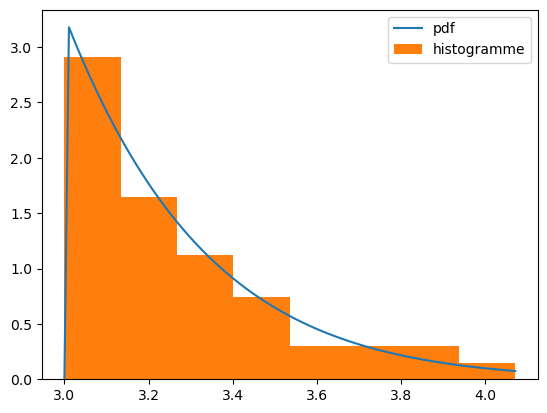

In [13]:
def normsupq(x,q,p):
    return sps.norm.pdf(x)*(x>q)/p

x_pdf = np.linspace(q, max(X), 100)

plt.plot(x_pdf, normsupq(x_pdf,q,p), label="pdf")
plt.hist(X,bins='auto',density=True, label="histogramme")
plt.legend();

#### Question 1.3 ####
On souhaite vérifier la pertinence du TCL du cadre idéal. Pour cela, effectuer par exemple $N=100$ fois la procédure précédente pour obtenir un échantillon de $N$ valeurs de $\hat p_n$. Comparer l'écart-type empirique de cet échantillon à l'écart-type théorique du cadre idéal. En utilisant par exemple la fonction `sps.gaussian_kde()`, comparer la distribution empirique de cet échantillon convenablement centré et renormalisé à celle d'une loi $\mathcal{N}(0,1)$. On pourra prendre $q=3$, $n=100$, $\rho=0.9$ et $T=20$. 

Durée (s) : 97.514
La vraie probabilité est 1.35e-03
L'écart-type empirique est 3.31e-04
L'écart-type théorique du cadre idéal est 3.47e-04


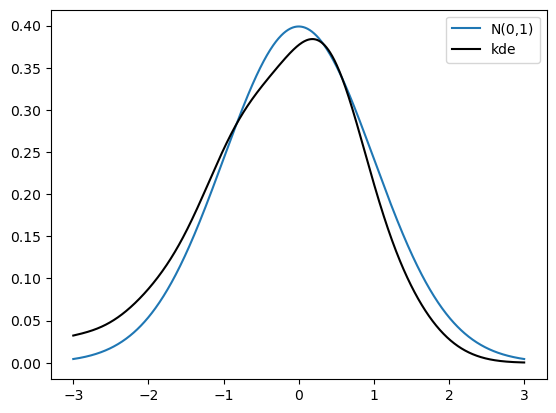

In [14]:
N = 100
n = 100
rho = 0.9
T = 20
q = 3
p = sps.norm.sf(q)
t0=perf_counter()
phat=np.zeros(n)

def noyau(L,rho,T,Xnew):
    for it in range(T):
        Y = rho*Xnew+np.sqrt(1-rho**2)*sps.norm.rvs()
        Xnew = Y*(Y>L)+Xnew*(Y<L)
    return Xnew

for it in range(N):
    X = sps.norm.rvs(size=n)
    Lmin = min(X)
    Imin = np.argmin(X)
    J=0

    while Lmin<q:
        Iclone = np.random.choice([i for i in range(n) if i != Imin])
        X[Imin] = noyau(Lmin,rho,T,X[Iclone])
        Lmin = min(X)
        Imin = np.argmin(X)
        J = J+1

    phat[it] = (1-1/n)**J

sdempirique = np.std(phat)
sdtheorique = np.sqrt(-p**2*np.log(p)/n)

print("Durée (s) : %1.3f" %(perf_counter()-t0))
print("La vraie probabilité est %1.2e" %p)
print("L'écart-type empirique est %1.2e" %sdempirique)
print("L'écart-type théorique du cadre idéal est %1.2e" %sdtheorique)


phatnorm = np.sqrt(n)*(phat-p)/(phat*np.sqrt(-np.log(phat)))
kde = sps.gaussian_kde(phatnorm)
x_pdf = np.linspace(-3, 3, num=1000)

plt.plot(x_pdf, sps.norm.pdf(x_pdf), label="N(0,1)")
plt.plot(x_pdf, kde(x_pdf), color="black", label="kde")
plt.legend();

#### Question 1.4 ####
On souhaite désormais estimer le quantile d'ordre $(1-p)$ c'est-à-dire, pour une valeur $p$ donnée, déterminer $q$ tel que $\mathbb{P}(\mathcal{N}(0,1)>q)=p$. Il suffit d'appliquer l'algorithme précédent jusqu'à l'itération $j_n:= \lceil \frac{\log p}{\log (1-n^{-1})}\rceil$ et poser 
$$\hat q_n:=L_{j_n}.$$
Dans un cadre "idéalisé", on appliquerait un nombre infini de fois le noyau à chaque étape et on aurait alors le résultat de normalité asymptotique suivant (en notant $\varphi$ la densité de la loi $\mathcal{N}(0,1))$ :
$$\sqrt{n}(\hat{q}_n-q)\xrightarrow[n\to\infty]{d}\mathcal{N}\left(0,\frac{-p^2\log p}{\varphi(q)^2}\right).$$
En notant
$$\hat\sigma_n:=\frac{p\sqrt{-\log p}}{\varphi(\hat{q}_n)},$$
ceci permet d'en déduire des intervalles de confiance asymptotiques. 

Implémenter cet algorithme pour estimer le quantile $q$ tel que $\mathbb{P}(\mathcal{N}(0,1)>q)=p$, ainsi qu'un intervalle de confiance asymptotique à $95\%$ issu de la convergence en loi ci-dessus. On pourra prendre $p=10^{-6}$, $n=100$, $\rho=0.9$ et $T=20$.

In [15]:
n = 100
rho = 0.9
T = 20
p = 10**(-6)
alpha = 0.05
q = sps.norm.ppf(1-p)


jn=int(np.ceil(np.log(p)/np.log(1-1/n)))

def noyau(L,rho,T,Xnew):
    for it in range(T):
        Y = rho*Xnew+np.sqrt(1-rho**2)*sps.norm.rvs()
        Xnew = Y*(Y>L)+Xnew*(Y<=L)
    return Xnew

t0 = perf_counter()
X = sps.norm.rvs(size=n)
Lmin = min(X)
Imin = np.argmin(X)


for j in range(1,1+jn):
    Iclone = np.random.choice([i for i in range(n) if i != Imin])
    X[Imin] = noyau(Lmin,rho,T,X[Iclone])
    Lmin = min(X)
    Imin = np.argmin(X)

qhat = Lmin
sigmahat = p*np.sqrt(-np.log(p))/sps.norm.pdf(qhat)

borneinf = qhat - sps.norm.ppf(1-alpha/2)*sigmahat/np.sqrt(n)
bornesup = qhat + sps.norm.ppf(1-alpha/2)*sigmahat/np.sqrt(n)

print("Durée (s) : %1.3f" %(perf_counter()-t0))
print("Le vrai quantile est %1.3f" %q)
print("Son estimation est %1.3f" %qhat)
print(f"Intervalle de confiance asymptotique : [{borneinf:1.3f},{bornesup:1.3f}]")

Durée (s) : 2.258
Le vrai quantile est 4.753
Son estimation est 4.737
Intervalle de confiance asymptotique : [4.601,4.873]


#### Question 1.5 ####
En général, on ne connaît pas la densité $\varphi(q)$ apparaissant au dénominateur du TCL
$$\sqrt{n}(\hat{q}_n-q)\xrightarrow[n\to\infty]{d}\mathcal{N}\left(0,\frac{-p^2\log p}{\varphi(q)^2}\right).$$
Dans ce cas, on a vu en Amphi 4 que si
$$j_n^\pm:= -n\log p\pm1.96\sqrt{-n\log p}$$
alors un IC de niveau asymptotique $95\%$ est 
$$\left[L_{\lfloor j_n^-\rfloor},L_{\lceil j_n^+\rceil}\right].$$
Pour cela, effectuer par exemple $N=100$ fois la procédure précédente pour obtenir $N$ intervalles de confiance de niveau asymptotique $95\%$. Afficher le pourcentage de fois où la vraie valeur de $q$ est dans l'intervalle de confiance. 

In [19]:
N = 100
n = 100
rho = 0.9
T = 20
q = 3
p = sps.norm.sf(q)
alpha = 0.05


jn=int(np.ceil(np.log(p)/np.log(1-1/n)))
jnm = int(np.floor(-n * np.log(p) - sps.norm.ppf(1 - alpha / 2) * np.sqrt(-n * np.log(p))))
jnp = int(np.ceil(-n * np.log(p) + sps.norm.ppf(1 - alpha / 2) * np.sqrt(-n * np.log(p))))

t0 = perf_counter()
qhat=np.zeros(N)
qhatm=np.zeros(N)
qhatp=np.zeros(N)
flags = 0

def noyau(L,rho,T,Xnew):
    for it in range(T):
        Y = rho*Xnew+np.sqrt(1-rho**2)*sps.norm.rvs()
        Xnew = Y*(Y>L)+Xnew*(Y<L)
    return Xnew
t0 = perf_counter()

for it in range(N):
    X = sps.norm.rvs(size=n)
    Lmin = min(X)
    Imin = np.argmin(X)

    for j in range(1, 1 + jnm):
        Iclone = np.random.choice([i for i in range(n) if i != Imin])
        X[Imin] = noyau(Lmin,rho,T,X[Iclone])
        Lmin = min(X)
        Imin = np.argmin(X)

    qhatm[it] = Lmin

    for j in range(1 + jnm, 1 + jnp):
        Iclone = np.random.choice([i for i in range(n) if i != Imin])
        X[Imin] = noyau(Lmin,rho,T,X[Iclone])
        Lmin = min(X)
        Imin = np.argmin(X)

    qhatp[it] = Lmin

    flags = flags + int(q > qhatm[it] and q < qhatp[it])

print("Durée (s) : %1.3f" %(perf_counter()-t0))

print("Pourcentage de fois où le quantile est dans l'IC :", 100 * flags / N)

Durée (s) : 105.721
Pourcentage de fois où le quantile est dans l'IC : 98.0


## Exercice 2 : le cadre dynamique

On considère un processus stochastique en dimension 1 :
$$dX(t)=-V'(X(t)) dt + \sqrt{2 \varepsilon}\ dB(t)$$
où $V:\mathbb R \to \mathbb R$ est une fonction potentielle, $\varepsilon >0$ fixe l'intensité du bruit et $(B(t))_{t \ge 0}$ est un mouvement brownien standard. Pour deux réels $a<b$, on note $\tau_a= \inf\{t \ge 0, X(t)<a\}$ et  $\tau_b= \inf\{t \ge 0, X(t)>b\}$. Pour une condition initiale $X(0)=x_0 \in (a,b)$ fixée, on souhaite évaluer
$$p=\mathbb P(\tau_b < \tau_a)$$
dans le cas où cette probabilité est très petite.

On introduit un pas de temps $\delta_t>0$ et la discrétisation suivante : pour tout $k \ge 0$,
$$X_{k+1} = X_k - V'(X_k) \delta_t + \sqrt{2 \varepsilon \delta_t}\ G_k$$
où $(G_k)_{k \ge 0}$ est une suite i.i.d. de gaussiennes centrées réduites. On considère donc des trajectoires $(X_k)_{0 \le k \le T_a \wedge T_b}$ où $T_a=\min\{k\ge 0, \, X_k < a\}$ et $T_b=\min\{k\ge 0, \, X_k > b\}$.

#### Question 2.0 #### 
Représenter la fonction potentielle $V(x)=\frac{x^4}{4}-\frac{x^2}{2}$ sur l'intervalle $[-1.5;1.5]$.

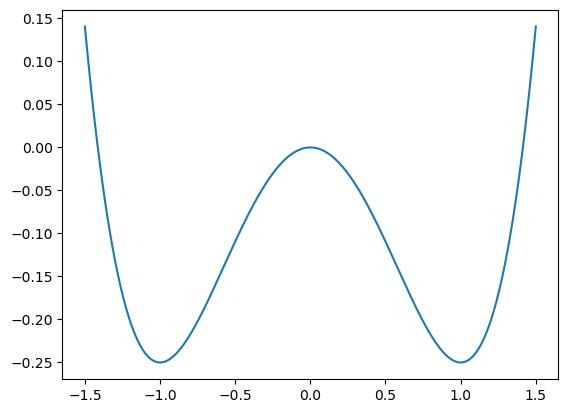

In [24]:
v = lambda x : x**4/4-x**2/2
plt.plot(np.linspace(-1.5,1.5,1000),v(np.linspace(-1.5,1.5,1000)))
plt.show()

#### Question 2.1 #### 
Simuler et afficher une trajectoire $(X_k)_{0 \le k \le T_a \wedge T_b}$ de cette dynamique pour la fonction potentielle $V$ ci-dessus et les paramètres suivants : $a=-0.9$, $b=0.9$, $x_0=-0.89$, $\varepsilon=0.02$, $\delta_t=0.001$. 

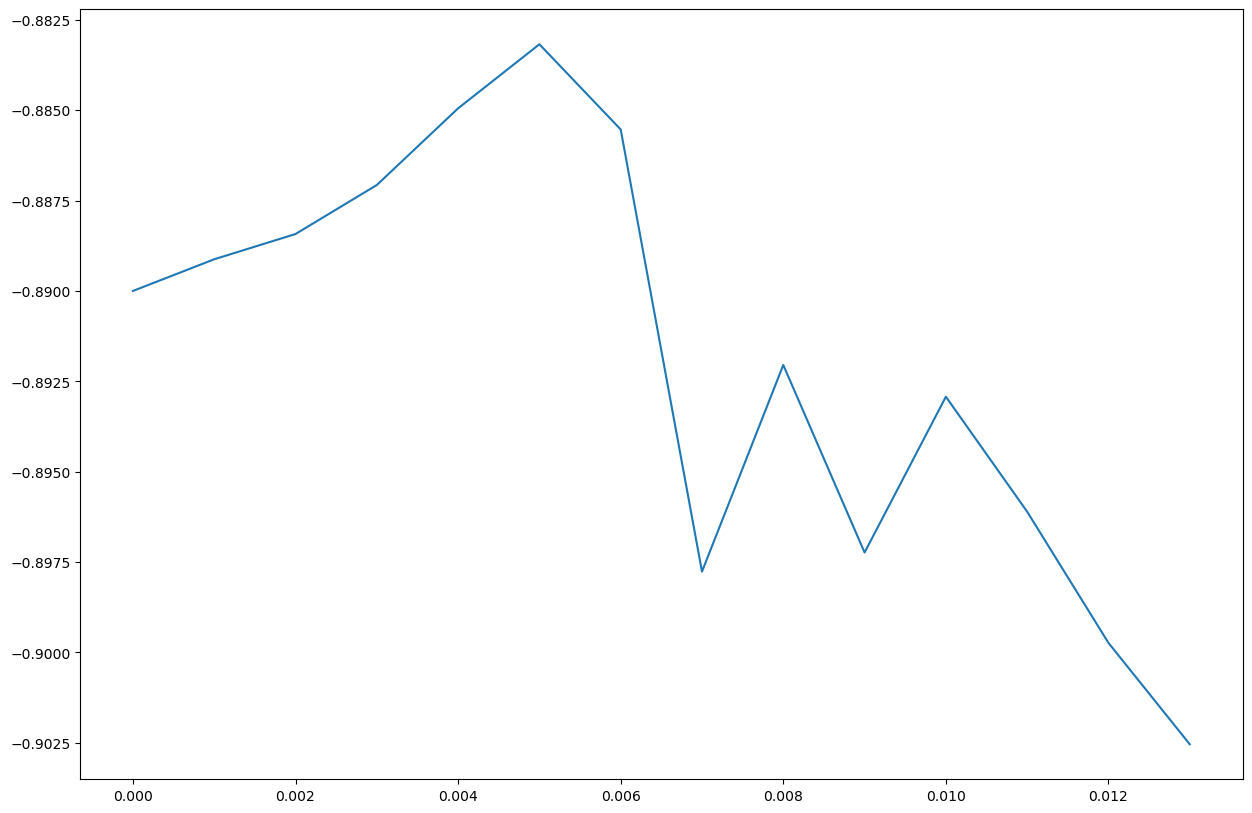

In [52]:
a = -0.9
b = 0.9
x0 = -0.89
epsilon = 0.02
dt = 0.001
sigma = np.sqrt(2*epsilon*dt)
max_iter=int(1e6)
V_prime = lambda x : x**3-x
trajectory,i=[x0],0
while trajectory[i]>a and trajectory[i]<b and i < max_iter:
    trajectory.append( trajectory[-1]-V_prime(trajectory[-1])*dt + np.sqrt(2*epsilon*dt)*np.random.randn(1))
    #trajectory[i+1]=trajectory[i]-
    i+=1

plt.figure(figsize=(15, 10))


x=np.arange(i+1)*dt
plt.plot(x,trajectory[0:i+1])
plt.show()

#### Question 2.2 #### 
Estimer $p=\mathbb P(T_b<T_a)$ par un estimateur Monte-Carlo naïf (avec un intervalle de confiance de niveau asymptotique $95\%$), d'abord pour $\varepsilon=1$, puis pour $\varepsilon=0.02$. On pourra prendre un échantillon de taille $n=1000$.

In [39]:
epsilon = 1
alpha = 0.05
sigma = np.sqrt(2*epsilon*dt)
n = 1000
max_iter= 50000
#epsilon=0.01
epsilon=1

count=0
for m in np.arange(n):
    t=x0
    while t>=a and t<=b and i<max_iter:
        tra=t-V_prime(t)*dt+np.sqrt(sigma)*np.random.randn(1)
    if t>b:
        count=count+1
p=count/n
print("Estimation de la probabilité :",p,"+/-",1.96*np.sqrt(p*(1-p)/n))


KeyboardInterrupt: 

In [49]:
#epsilon=0.01
epsilon=1
from numpy import *
from numpy.random import *
M=10000 # Nombre d'échantillons Monte Carlo
max_length = 500000
count=0
for m in arange(M):
    tra=x0
    while tra>=a and tra<=b and i<max_length-1:
        tra=tra-V_prime(tra)*dt+sqrt(2*epsilon*dt)*randn(1)
    if tra>b:
        count=count+1
p=count/M
print("Estimation de la probabilité :",p,"+/-",1.96*sqrt(p*(1-p)/M))


Estimation de la probabilité : 0.0198 +/- 0.0027305241096902987


#### Question 2.3 #### 
Nous allons maintenant programmer l'algorithme AMS (Adaptive Multilevel Splitting) vu en cours, en commençant par l'initialisation qui correspond à :
* Construire une liste de $n$ trajectoires $(X^i_k)_{0 \le k \le T_a \wedge T_b}$, pour $0 \le i \le n-1$,
* Calculer le premier niveau $L_1=\min_{0 \le i \le n-1}\max_{0 \le k \le T_a \wedge T_b} X^i_k$,
* Déterminer l'ensemble des indices des trajectoire à tuer : $\mathcal K=\{0 \le i \le n-1,\ \max_{0 \le k \le T_a \wedge T_b}X^i_k=L_1\}$,
* Initialiser l'estimateur de la probabilité : $\hat p_n=1-\frac{|\mathcal K|}{n}$.

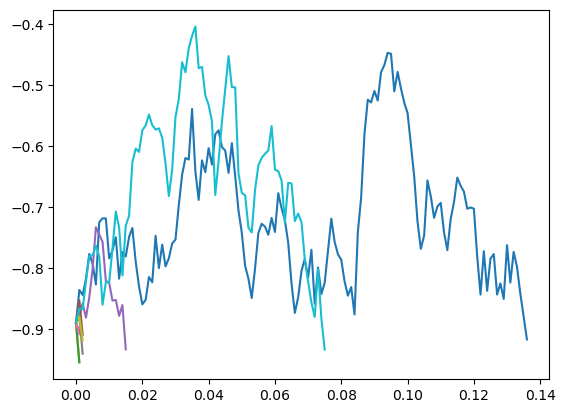

In [299]:

epsilon=1
M=10

ams_trajectory=[]
for m in arange(M):
    traj=zeros(max_length)
    traj[0]=x0
    i=0
    while traj[i]>=a and traj[i]<=b and i<max_length-1:
        traj[i+1]=traj[i]-V_prime(traj[i])*dt+sqrt(2*epsilon*dt)*randn(1)
        i=i+1
    length=i+1
    ams_trajectory.append(traj[0:length])

# Calcul des maxima

traj_AMS_max=zeros(M)
for m in arange(M):
    traj_AMS_max[m]=max(ams_trajectory[m])

kill_flag=argmin(traj_AMS_max)
zkill=traj_AMS_max[kill_flag]
def plot_traj(l,t):
    x=arange(l)*dt
    plt.figure(1)
    plt.plot(x,t[0:l])
    plt.grid()
# Affichage
for m in arange(M):
    plot_traj(ams_trajectory[m].size, ams_trajectory[m])


#### Question 2.4 #### 
Programmer ensuite les itérations d'AMS c'est-à-dire, tant que $L \le b$ et pour chaque $i\in \mathcal K$ :
* Tirer un indice $I'$ au hasard parmi $\{0,\ldots,n-1\} \setminus \{\mathcal K\}$
* Recopier la trajectoire $X^{I'}$ sur $X^{i}$ jusqu'au premier indice $k$ où $X^{I'}_k> L$ (attention à l'inégalité stricte)
* Compléter cette trajectoire jusqu'à $T_a \wedge T_b$
* Mettre à jour $L$, $\mathcal K$ et l'estimateur $\hat p_n \leftarrow \left(1-\frac{|\mathcal K|}{n}\right)\hat p_n$

Faire des simulations avec $\varepsilon=1$ puis avec $\varepsilon=0.02$, et $n=100$. Pour l'intervalle de confiance asymptotique à 95%, on fera l'approximation selon laquelle une seule trajectoire est tuée à chaque itération, c'est-à-dire que comme dans l'exercice précédent
$$\sqrt{n}\left(\hat p_n-p\right)\xrightarrow[n\to\infty]{\textrm{loi}}\mathcal{N}(0,-p^2\log p).$$

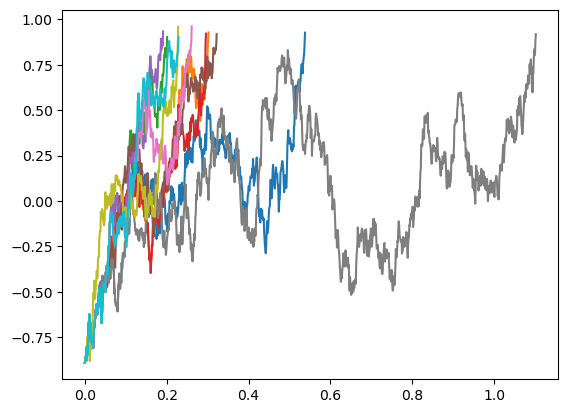

Estimation de la probabilité : 0.014780882941434608


In [300]:
new_traj=zeros(max_length)
iter=0
while(zkill<=b):
    copy_flag=choice([i for i in range(M) if i != kill_flag])
    ams_trajectory[kill_flag]=ams_trajectory[copy_flag]
    i0=0
    while ams_trajectory[kill_flag][i0]<=zkill:
        i0=i0+1
    new_traj[0]=ams_trajectory[kill_flag][i0]
    i=0
    while a <= new_traj[i] <= b and i<max_length-1:
        new_traj[i+1]=new_traj[i]-V_prime(new_traj[i])*dt+sqrt(2*epsilon*dt)*randn(1)
        i=i+1
    length=i+1
    ams_trajectory[kill_flag]=concatenate((ams_trajectory[kill_flag][0:i0], new_traj[0:length]))
    traj_AMS_max[kill_flag]=max(ams_trajectory[kill_flag])
    kill_flag=argmin(traj_AMS_max)
    print(kill_flag, argwhere(traj_AMS_max == traj_AMS_max.min()))
    zkill=traj_AMS_max[kill_flag]
    iter=iter+1
    clear_output()
    for m in arange(M):
        plot_traj(ams_trajectory[m].size, ams_trajectory[m])
    plt.show()
print("Estimation de la probabilité :",(1-1/M)**iter)

#### Question 2.5 #### 
On peut montrer que, lorsque $\varepsilon$ tend vers $0$, la durée $D$ d'une trajectoire réactive suit approximativement la loi suivante
$$D\overset{loi}{\approx} G-\log\varepsilon+c$$
où $G$ suit une loi de Gumbel standard et
$$c=\log(0.89 × 0.9)−\frac{1}{2}\log(1 − 0.89^2)−\frac{1}{2}\log(1 − 0.9^2)$$

Estimation de la probabilité : 0.016123426971928242 +/- 0.0022333452029769415


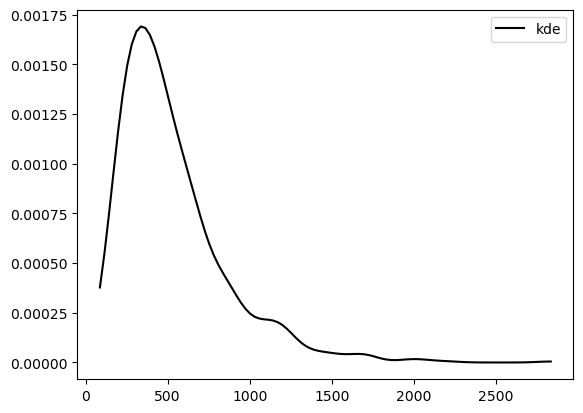

In [302]:

R=100 # Nombre de runs d'AMS
epsilon=1
M=10 # Nombre de trajectoires par AMS
proba=zeros(R)
longueur=zeros((R,M))

for r in arange(R):
    #print("Run",r)
    # Initialisation d'AMS
    ams_trajectory=[]
    estim_proba=1
    for m in arange(M):
        traj=zeros(max_length)
        traj[0]=x0
        i=0
        while traj[i]>=a and traj[i]<=b and i<max_length-1:
            traj[i+1]=traj[i]-V_prime(traj[i])*dt+sqrt(2*epsilon*dt)*randn(1)
            i=i+1
        length=i+1
        ams_trajectory.append(traj[0:length])
    traj_AMS_max=zeros(M)
    for m in arange(M):
        traj_AMS_max[m]=max(ams_trajectory[m])
    kill_flag=argwhere(traj_AMS_max == traj_AMS_max.min())
    zkill=traj_AMS_max.min()
    # Itérations d'AMS
    new_traj=zeros(max_length)
    iter=0
    while(zkill<=b):
        # Procédure de rééchantillonnage
        for k in arange(size(kill_flag)):
            ind_kill_current=kill_flag[k][0]
            copy_flag=choice([i for i in range(M) if i not in kill_flag])
            ams_trajectory[ind_kill_current]=ams_trajectory[copy_flag]
            i0=0
            while ams_trajectory[ind_kill_current][i0]<=zkill:
                i0=i0+1
            new_traj[0]=ams_trajectory[ind_kill_current][i0]
            i=0
            while new_traj[i]>=a and new_traj[i]<=b and i<max_length-1:
                new_traj[i+1]=new_traj[i]-V_prime(new_traj[i])*dt+sqrt(2*epsilon*dt)*randn(1)
                i=i+1
            length=i+1
            ams_trajectory[ind_kill_current]=concatenate((ams_trajectory[ind_kill_current][0:i0], new_traj[0:length]))
            traj_AMS_max[ind_kill_current]=max(ams_trajectory[ind_kill_current])
        estim_proba*=(1 - size(kill_flag) / M)
        kill_flag=argwhere(traj_AMS_max == traj_AMS_max.min())
        zkill=traj_AMS_max.min()
        iter=iter+1
    proba[r]=estim_proba
    for m in arange(M):
        longueur[r][m]=size(ams_trajectory[m])
print("Estimation de la probabilité :",mean(proba),"+/-",1.96*sqrt(var(proba)/R))
longueur_dens=ravel(longueur)
kde = sps.gaussian_kde(longueur_dens)
x_pdf = np.linspace(min(longueur_dens), max(longueur_dens), num=100)
plt.plot(x_pdf, kde(x_pdf), color="black", label="kde")
plt.legend();

**Remarque** : Le résultat théorique de convergence en loi pour la durée d'une trajectoire réactive est prouvé dans l'article suivant :  
F. Cérou, A. Guyader, T. Lelièvre, and F. Malrieu, [On the Length of One-Dimensional Reactive Paths](https://perso.lpsm.paris/~aguyader/files/papers/cglm.pdf), *ALEA*, 2013.
